In [ ]:
# Ссылка на соревнование https://www.kaggle.com/kartik2112/fraud-detection

In [155]:
#!pip install xgboost
#!pip install scikit-plot
#!pip install shap

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pandasql as ps
from varname import nameof

from h3 import h3
from geojson.feature import *
import json
from folium import Map, Marker, GeoJson
from folium.plugins import MarkerCluster
import branca.colormap as cm
from branca.colormap import linear
import folium

from math import sin, cos, sqrt, atan2, radians

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

import shap

import scikitplot as skplt
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [214]:
train = pd.read_csv('fraudTrain.csv')

In [99]:
def calc_distance(lat1, long1, lat2, long2):
    R = 6373.0 # approximate radius of earth in km
    lat1 = radians(lat1)
    lon1 = radians(long1)
    lat2 = radians(lat2)
    lon2 = radians(long2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [100]:
def get_feature_str(feature_name, target_name, df):
    agg_df = df.groupby([feature_name,target_name], as_index=False)\
            .aggregate({'unix_time' : 'count'})\
            .rename(columns = {'unix_time': 'cnt'})
    pivot_df = agg_df.pivot(index=feature_name, columns=target_name).fillna(0)
    flat_df = pd.DataFrame(pivot_df.to_records())
    flat_df.columns = [feature_name, 'target_0', 'target_1']
    flat_df['target_share'] = flat_df['target_1'] / (flat_df['target_0'] + flat_df['target_1'])
    flat_df.sort_values(by='target_share', ascending=False, inplace = True)
    flat_df.columns = [feature_name, feature_name + '_target_0_cnt', feature_name + '_target_1_cnt', feature_name + '_target_share']
    flat_df = flat_df.drop(feature_name + '_target_0_cnt', axis = 1)
    return flat_df

In [101]:
def preprocess_features(df):
    print('Preprocess features: person_name, trans_hour, trans_dttm, dob, trans_week_day')
    df['person_name'] = df['first'] + ' ' + df['last']
    df['trans_hour'] = df['trans_date_trans_time'].str[11:13]
    df['trans_dttm'] = pd.to_datetime(df['trans_date_trans_time'])
    df['dob'] = pd.to_datetime(df['dob'])
    df['dob'] = df['dob'].astype('int64') // 10**9
    df['trans_week_day'] = df['trans_dttm'].apply(lambda x: x.strftime('%A'))
    print('Preprocess feature: trans_coords_hex_id')
    df['trans_coords_hex_id'] = df.apply(lambda row: h3.geo_to_h3(row["merch_lat"], row["merch_long"], 3), axis = 1)
    print('Preprocess feature: person_coords_hex_id')
    df['person_coords_hex_id'] = df.apply(lambda row: h3.geo_to_h3(row["lat"], row["long"], 3), axis = 1)
    print('Preprocess feature: trans_distance')
    df['trans_distance'] = df.apply(lambda row: calc_distance(row["lat"], row["long"], row["merch_lat"], row["merch_long"]), axis = 1)
    return df

In [102]:
categorical_feature_list = ['person_name', 'cc_num', 'dob', 'job', 'gender',          # person
                            'zip', 'street', 'city', 'state', 'person_coords_hex_id', # person geo
                            'trans_hour', 'trans_week_day', 'trans_coords_hex_id',    # transaction
                            'merchant', 'category']                                   # merchant

In [103]:
def convert_catorical_features_train(df_train, categorical_feature_list):
    if len(set(df_train.columns) & set(categorical_feature_list)) < len(categorical_feature_list):
        print('Not enough columns in df. Be shure that you run preprocess_features first')
    for feature_name in categorical_feature_list:
        print('Convert feature: ' + feature_name)
        feature_str = get_feature_str(feature_name, 'is_fraud', df_train)
        df_train = df_train.merge(feature_str, on=feature_name, how='left')
    return df_train

In [104]:
def convert_catorical_features_test(df_train, df_test, categorical_feature_list):
    if len(set(df_test.columns) & set(categorical_feature_list)) < len(categorical_feature_list):
        print('Not enough columns in df. Be shure that you run preprocess_features first')
    for feature_name in categorical_feature_list:
        print('Convert feature: ' + feature_name)
        feature_str = get_feature_str(feature_name, 'is_fraud', df_train)
        df_test = df_test.merge(feature_str, on=feature_name, how='left')
        df_test[feature_name].fillna(df_test[feature_name].mean(skipna = True), inplace = True)
    return df_test

In [105]:
def one_hot_encode(df, col_name):
    for i in list(col_name):
        one_hot = pd.get_dummies(df[i])
        one_hot.columns = i + '_' + one_hot.columns
        df = df.drop(i, axis = 1)
        df = df.join(one_hot)
    return df

In [106]:
def one_hot_encode_train(train_df, feature_list):
    for i in list(feature_list):
        one_hot = pd.get_dummies(train_df[i])
        one_hot.columns = i + '_' + one_hot.columns
        train_df = train_df.drop(i, axis = 1)
        train_df = train_df.join(one_hot)
    return train_df

In [107]:
def one_hot_encode_test(train_df, test_df, feature_list):
    for i in list(feature_list):
        one_hot = pd.get_dummies(train_df[i])
        one_hot.columns = i + '_' + one_hot.columns
        train_df = train_df.drop(i, axis = 1)
        train_df = train_df.join(one_hot)
        train_df[i].fillna(value=train_df[i].mean(skipna=True), inplace=True)
    return train_df

In [108]:
train_step_1 = preprocess_features(train)

Preprocess features: person_name, trans_hour, trans_dttm, dob, trans_week_day
Preprocess feature: trans_coords_hex_id
Preprocess feature: person_coords_hex_id
Preprocess feature: trans_distance


In [109]:
train_step_2 = convert_catorical_features_train(train_step_1, categorical_feature_list)

Convert feature: person_name
Convert feature: cc_num
Convert feature: dob
Convert feature: job
Convert feature: gender
Convert feature: zip
Convert feature: street
Convert feature: city
Convert feature: state
Convert feature: person_coords_hex_id
Convert feature: trans_hour
Convert feature: trans_week_day
Convert feature: trans_coords_hex_id
Convert feature: merchant
Convert feature: category


In [110]:
train_step_3 = one_hot_encode_train(train_step_2, ['gender'])

In [111]:
cols_to_drop = ['Unnamed: 0','category', 'person_name', 'first', 'last', 'cc_num', 'dob', 'job', 'lat', 'long',                    # person
                'zip', 'street', 'city', 'state', 'city_pop', 'person_coords_hex_id', # person geo
                'trans_hour', 'trans_week_day', 'trans_coords_hex_id', 'trans_date_trans_time',
                'trans_num','trans_dttm', 'unix_time', 'merch_lat', 'merch_long',# transaction
                'merchant']
train_step_4 = train_step_3.drop(cols_to_drop, axis = 1)

# Learning Model

In [ ]:
# Sampling
#sample_none_fraud = train.loc[train.is_fraud == 0,:].sample(n=1000000, random_state=123)
#sample_fraud = train.loc[train.is_fraud == 1,:].sample(n=7500, random_state=123)
#train = sample_none_fraud.append(sample_fraud)

In [199]:
X = train_step_4.drop('is_fraud', axis = 1)
y = train_step_4.loc[:,'is_fraud']

In [135]:
model = XGBClassifier()

In [136]:
model.fit(X, y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [137]:
expected = y
predicted = model.predict(X)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.97      0.85      0.91      7506

    accuracy                           1.00   1296675
   macro avg       0.98      0.93      0.95   1296675
weighted avg       1.00      1.00      1.00   1296675

[[1288960     209]
 [   1089    6417]]


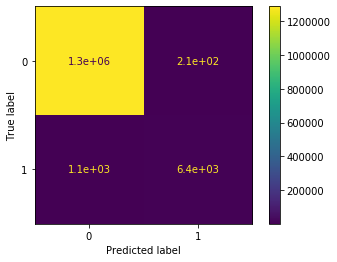

In [138]:
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
plot_confusion_matrix(model, X, y)

In [ ]:
y_true = y # ground truth labels
y_probas = model.predict_proba(X) # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc(y_true, y_probas)
plt.show()

In [ ]:
rf_shap_values = shap.KernelExplainer(predicted,X)

In [ ]:
shap.summary_plot(shap_test, df, max_display=25, auto_size_plot=True)

In [160]:
explainer = shap.TreeExplainer(model)

In [161]:
shap_values = explainer.shap_values(X)

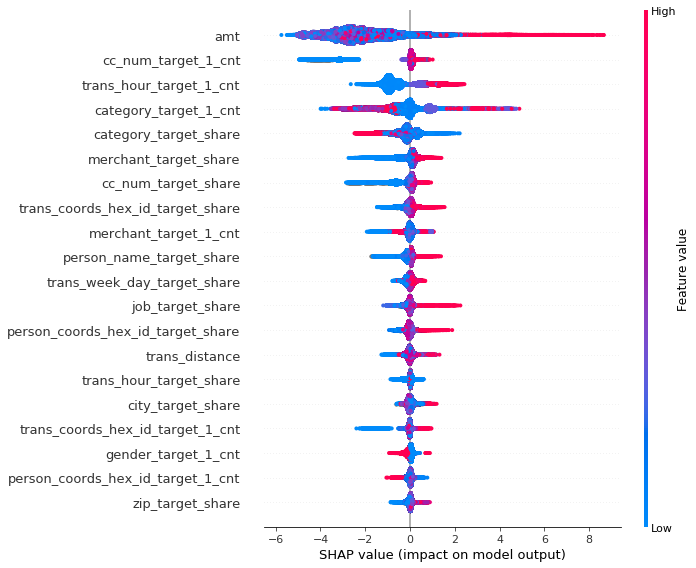

In [163]:
shap.summary_plot(shap_values, X)

значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
чем толще линия на графике, тем больше таких точек наблюдения
чем краснее точки на графике, тем выше значения фичи в ней

In [ ]:
#data_tuples = list(zip(y_true,list(y_probas[:,1])))

In [ ]:
#compare = pd.DataFrame(data_tuples, columns=['y_true','y_probas'])

In [ ]:
#compare.loc[compare['y_true']==1,:].head(40)

In [ ]:
#compare.loc[(compare['y_true']==0) & (compare['y_probas'] > 0.5),:].shape

In [ ]:
#compare.loc[(compare['y_true']==0) & (compare['y_probas'] > 0.2),:].shape

# Test Model

In [139]:
test = pd.read_csv('fraudTest.csv')

In [140]:
#test = test.head(10000)

In [141]:
test_step_1 = preprocess_features(test)

Preprocess features: person_name, trans_hour, trans_dttm, dob, trans_week_day
Preprocess feature: trans_coords_hex_id
Preprocess feature: person_coords_hex_id
Preprocess feature: trans_distance


In [142]:
test_step_1.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,person_name,trans_hour,trans_dttm,trans_week_day,trans_coords_hex_id,person_coords_hex_id,trans_distance
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,-56419200,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,Jeff Elliott,12,2020-06-21 12:14:25,Sunday,8344dcfffffffff,8344defffffffff,24.569172
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",632534400,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,Joanne Williams,12,2020-06-21 12:14:33,Sunday,832691fffffffff,832690fffffffff,104.958031
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",25315200,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,Ashley Lopez,12,2020-06-21 12:14:53,Sunday,832a10fffffffff,832a10fffffffff,59.098624
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,554169600,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,Brian Williams,12,2020-06-21 12:15:15,Sunday,8344a9fffffffff,8344a9fffffffff,27.707262
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,-457315200,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,Nathan Massey,12,2020-06-21 12:15:17,Sunday,832741fffffffff,83274cfffffffff,104.367859


In [20]:
#categorical_feature_list = ['person_name']

In [248]:
def convert_catorical_features_test(df_train, df_test, categorical_feature_list):
    if len(set(df_test.columns) & set(categorical_feature_list)) < len(categorical_feature_list):
        print('Not enough columns in df. Be shure that you run preprocess_features first')
    for feature_name in categorical_feature_list:
        print('Convert feature: ' + feature_name)
        #print('get feature str: ' + feature_name)
        feature_str = get_feature_str(feature_name, 'is_fraud', df_train)
        #print('merge feature str: ' + feature_name)
        df_test = df_test.merge(feature_str, on=feature_name, how='left')
        #print(feature_str[feature_name + '_target_1_cnt'].mean(skipna = True))
        #print(feature_str[feature_name + '_target_1_cnt'])
        #print(feature_str[feature_name + '_target_1_cnt'].describe())
#        print('fill na values: ' + feature_name)
#        df_test[feature_name].fillna(feature_str[feature_name + '_target_1_cnt'].mean(skipna = True), inplace = True)
        df_test[feature_name + '_target_1_cnt'].fillna(0, inplace = True)
        df_test[feature_name + '_target_share'].fillna(0, inplace = True)
#        df_test[feature_name].fillna(0, inplace = True)
#    return feature_str
    return df_test

In [115]:
#person_name_target_share

In [144]:
%%time
test_step_2 = convert_catorical_features_test(df_train = train_step_1, df_test = test_step_1, categorical_feature_list = categorical_feature_list)

Convert feature: person_name
Convert feature: cc_num
Convert feature: dob
Convert feature: job
Convert feature: gender
Convert feature: zip
Convert feature: street
Convert feature: city
Convert feature: state
Convert feature: person_coords_hex_id
Convert feature: trans_hour
Convert feature: trans_week_day
Convert feature: trans_coords_hex_id
Convert feature: merchant
Convert feature: category
Wall time: 18.4 s


In [145]:
test_step_2.shape

(555719, 60)

In [146]:
test_step_3 = one_hot_encode(test_step_2, ['gender'])

In [147]:
test_step_3.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,person_name,trans_hour,trans_dttm,trans_week_day,trans_coords_hex_id,person_coords_hex_id,trans_distance,person_name_target_1_cnt,person_name_target_share,cc_num_target_1_cnt,cc_num_target_share,dob_target_1_cnt,dob_target_share,job_target_1_cnt,job_target_share,gender_target_1_cnt,gender_target_share,zip_target_1_cnt,zip_target_share,street_target_1_cnt,street_target_share,city_target_1_cnt,city_target_share,state_target_1_cnt,state_target_share,person_coords_hex_id_target_1_cnt,person_coords_hex_id_target_share,trans_hour_target_1_cnt,trans_hour_target_share,trans_week_day_target_1_cnt,trans_week_day_target_share,trans_coords_hex_id_target_1_cnt,trans_coords_hex_id_target_share,merchant_target_1_cnt,merchant_target_share,category_target_1_cnt,category_target_share,gender_F,gender_M
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,-56419200,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,Jeff Elliott,12,2020-06-21 12:14:25,Sunday,8344dcfffffffff,8344defffffffff,24.569172,12.0,0.007687,12.0,0.007687,12.0,0.007687,49.0,0.008700,3771,0.006426,12.0,0.007687,12.0,0.007687,12.0,0.007687,193.0,0.006612,41.0,0.011323,67,0.001027,1216,0.004853,30.0,0.006392,2.0,0.001101,220,0.002424,0,1
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",632534400,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,Joanne Williams,12,2020-06-21 12:14:33,Sunday,832691fffffffff,832690fffffffff,104.958031,14.0,0.006702,14.0,0.006702,14.0,0.006702,38.0,0.006888,3735,0.005262,14.0,0.006702,14.0,0.006702,14.0,0.006702,61.0,0.005701,14.0,0.006702,67,0.001027,1216,0.004853,10.0,0.006180,5.0,0.002740,220,0.002424,1,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",25315200,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,Ashley Lopez,12,2020-06-21 12:14:53,Sunday,832a10fffffffff,832a10fffffffff,59.098624,7.0,0.002716,7.0,0.002716,7.0,0.002716,18.0,0.002910,3735,0.005262,7.0,0.002716,7.0,0.002716,7.0,0.002716,555.0,0.006647,216.0,0.006779,67,0.001027,1216,0.004853,110.0,0.007063,2.0,0.001166,133,0.001549,1,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,554169600,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,Brian Williams,12,2020-06-21 12:15:15,Sunday,8344a9fffffffff,8344a9fffffffff,27.707262,0.0,0.000000,0.0,0.000000,0.0,0.000000,19.0,0.012298,3771,0.006426,0.0,0.000000,0.0,0.000000,0.0,0.000000,281.0,0.006585,10.0,0.002810,67,0.001027,1216,0.004853,20.0,0.005884,7.0,0.004297,250,0.003139,0,1
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,-457315200,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,Nathan Massey,12,2020-06-21 12:15:17,Sunday,832741fffffffff,83274cfffffffff,104.367859,11.0,0.005408,11.0,0.005408,11.0,0.005408,20.0,0.009790,3771,0.006426,11.0,0.005408,11.0,0.005408,11.0,0.005408,238.0,0.005157,19.0,0.006203,67,0.001027,1216,0.004853,11.0,0.003421,1.0,0.001203,116,0.002864,0,1


In [148]:
test_step_4 = test_step_3.drop(cols_to_drop, axis = 1)

In [149]:
test_step_4.head()

,amt,is_fraud,trans_distance,person_name_target_1_cnt,person_name_target_share,cc_num_target_1_cnt,cc_num_target_share,dob_target_1_cnt,dob_target_share,job_target_1_cnt,job_target_share,gender_target_1_cnt,gender_target_share,zip_target_1_cnt,zip_target_share,street_target_1_cnt,street_target_share,city_target_1_cnt,city_target_share,state_target_1_cnt,state_target_share,person_coords_hex_id_target_1_cnt,person_coords_hex_id_target_share,trans_hour_target_1_cnt,trans_hour_target_share,trans_week_day_target_1_cnt,trans_week_day_target_share,trans_coords_hex_id_target_1_cnt,trans_coords_hex_id_target_share,merchant_target_1_cnt,merchant_target_share,category_target_1_cnt,category_target_share,gender_F,gender_M
0,2.86,0,24.569172,12.0,0.007687,12.0,0.007687,12.0,0.007687,49.0,0.008700,3771,0.006426,12.0,0.007687,12.0,0.007687,12.0,0.007687,193.0,0.006612,41.0,0.011323,67,0.001027,1216,0.004853,30.0,0.006392,2.0,0.001101,220,0.002424,0,1
1,29.84,0,104.958031,14.0,0.006702,14.0,0.006702,14.0,0.006702,38.0,0.006888,3735,0.005262,14.0,0.006702,14.0,0.006702,14.0,0.006702,61.0,0.005701,14.0,0.006702,67,0.001027,1216,0.004853,10.0,0.006180,5.0,0.002740,220,0.002424,1,0
2,41.28,0,59.098624,7.0,0.002716,7.0,0.002716,7.0,0.002716,18.0,0.002910,3735,0.005262,7.0,0.002716,7.0,0.002716,7.0,0.002716,555.0,0.006647,216.0,0.006779,67,0.001027,1216,0.004853,110.0,0.007063,2.0,0.001166,133,0.001549,1,0
3,60.05,0,27.707262,0.0,0.000000,0.0,0.000000,0.0,0.000000,19.0,0.012298,3771,0.006426,0.0,0.000000,0.0,0.000000,0.0,0.000000,281.0,0.006585,10.0,0.002810,67,0.001027,1216,0.004853,20.0,0.005884,7.0,0.004297,250,0.003139,0,1
4,3.19,0,104.367859,11.0,0.005408,11.0,0.005408,11.0,0.005408,20.0,0.009790,3771,0.006426,11.0,0.005408,11.0,0.005408,11.0,0.005408,238.0,0.005157,19.0,0.006203,67,0.001027,1216,0.004853,11.0,0.003421,1.0,0.001203,116,0.002864,0,1


In [150]:
X = test_step_4.drop('is_fraud', axis = 1)
y = test_step_4.loc[:,'is_fraud']

In [151]:
expected = y
predicted = model.predict(X)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.02      0.00      0.00      2145

    accuracy                           1.00    555719
   macro avg       0.51      0.50      0.50    555719
weighted avg       0.99      1.00      0.99    555719

[[553341    233]
 [  2141      4]]


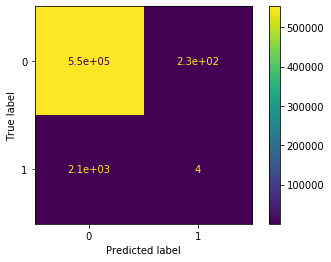

In [152]:
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
plot_confusion_matrix(model, X, y)

In [ ]:
train.loc[train['cc_num'] == 2291163933867244,:]

In [121]:
test_step_2.loc[test_step_2['person_name'] == 'Jeff Elliott',:]

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,person_name,trans_hour,trans_dttm,trans_week_day,trans_coords_hex_id,person_coords_hex_id,trans_distance,person_name_target_1_cnt,person_name_target_share,cc_num_target_1_cnt,cc_num_target_share,dob_target_1_cnt,dob_target_share,job_target_1_cnt,job_target_share,gender_target_1_cnt,gender_target_share,zip_target_1_cnt,zip_target_share,street_target_1_cnt,street_target_share,city_target_1_cnt,city_target_share,state_target_1_cnt,state_target_share,person_coords_hex_id_target_1_cnt,person_coords_hex_id_target_share,trans_hour_target_1_cnt,trans_hour_target_share,trans_week_day_target_1_cnt,trans_week_day_target_share,trans_coords_hex_id_target_1_cnt,trans_coords_hex_id_target_share,merchant_target_1_cnt,merchant_target_share,category_target_1_cnt,category_target_share
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,-56419200,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,Jeff Elliott,12,2020-06-21 12:14:25,Sunday,8344dcfffffffff,8344defffffffff,24.569172,12.0,0.007687,12.0,0.007687,12.0,0.007687,49.0,0.0087,3771,0.006426,12.0,0.007687,12.0,0.007687,12.0,0.007687,193.0,0.006612,41.0,0.011323,67,0.001027,1216,0.004853,30.0,0.006392,2.0,0.001101,220,0.002424
606,606,2020-06-21 15:39:04,2291163933867244,fraud_Goyette-Gerhold,kids_pets,17.15,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,-56419200,2ba65201d0c9119227e27b6640ff4415,1371829144,34.235448,-81.649282,0,Jeff Elliott,15,2020-06-21 15:39:04,Sunday,8344dcfffffffff,8344defffffffff,72.256008,12.0,0.007687,12.0,0.007687,12.0,0.007687,49.0,0.0087,3771,0.006426,12.0,0.007687,12.0,0.007687,12.0,0.007687,193.0,0.006612,41.0,0.011323,79,0.001208,1216,0.004853,30.0,0.006392,2.0,0.000877,239,0.002114


In [ ]:
test_step_2.head()

In [ ]:
train_step_3 = one_hot_encode(train_step_2, ['gender'])

In [ ]:
train_step_4 = train_step_3.drop(cols_to_drop, axis = 1)

In [183]:
train_step_4['cc_num_target_1_cnt'].describe().round(0)

count    1296675.0
mean           7.0
std            5.0
min            0.0
25%            2.0
50%            8.0
75%           11.0
max           19.0
Name: cc_num_target_1_cnt, dtype: float64

In [184]:
test_step_4['cc_num_target_1_cnt'].describe().round(0)

count    555556.0
mean          7.0
std           5.0
min           0.0
25%           2.0
50%           8.0
75%          11.0
max          19.0
Name: cc_num_target_1_cnt, dtype: float64

In [200]:
#from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [202]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [204]:
y_hat = [round(yhat) for yhat in model.predict(X_test)]
print(accuracy_score(y_test, y_hat))

0.9983843291495555


In [205]:
expected = y_test
predicted = model.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.92      0.80      0.85      1520

    accuracy                           1.00    259335
   macro avg       0.96      0.90      0.93    259335
weighted avg       1.00      1.00      1.00    259335

[[257707    108]
 [   311   1209]]


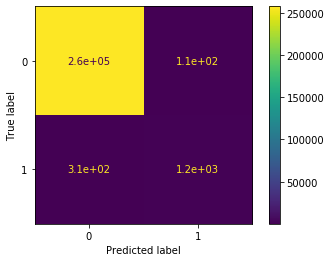

In [207]:
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
plot_confusion_matrix(model, X_test, y_test)

In [210]:
X_test = test_step_4.drop('is_fraud', axis = 1)
y_test = test_step_4.loc[:,'is_fraud']

In [211]:
expected = y_test
predicted = model.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.02      0.00      0.00      2145

    accuracy                           1.00    555719
   macro avg       0.51      0.50      0.50    555719
weighted avg       0.99      1.00      0.99    555719

[[553338    236]
 [  2140      5]]


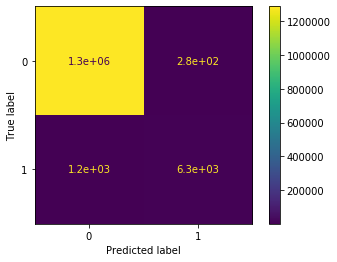

In [212]:
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
plot_confusion_matrix(model, X, y)

In [ ]:
#from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Manual train test split

In [277]:
# Sampling
train = pd.read_csv('fraudTrain.csv')
test  = train.iloc[1000000:(train.shape[0]+1),:]
train = train.iloc[0:1000000,:]

In [221]:
train_step_1 = preprocess_features(train)
train_step_2 = convert_catorical_features_train(train_step_1, categorical_feature_list)
train_step_3 = one_hot_encode(train_step_2, ['gender'])
train_step_4 = train_step_3.drop(cols_to_drop, axis = 1)
X_train      = train_step_4.drop('is_fraud', axis = 1)
y_train      = train_step_4.loc[:,'is_fraud']

Preprocess features: person_name, trans_hour, trans_dttm, dob, trans_week_day
Preprocess feature: trans_coords_hex_id
Preprocess feature: person_coords_hex_id
Preprocess feature: trans_distance


In [230]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [249]:
test_step_1 = preprocess_features(test)
test_step_2 = convert_catorical_features_test(df_train = train_step_1,
                                              df_test  = test_step_1,
                                              categorical_feature_list = categorical_feature_list)

Preprocess features: person_name, trans_hour, trans_dttm, dob, trans_week_day
Preprocess feature: trans_coords_hex_id
Preprocess feature: person_coords_hex_id
Preprocess feature: trans_distance
Convert feature: person_name
Convert feature: cc_num
Convert feature: dob
Convert feature: job
Convert feature: gender
Convert feature: zip
Convert feature: street
Convert feature: city
Convert feature: state
Convert feature: person_coords_hex_id
Convert feature: trans_hour
Convert feature: trans_week_day
Convert feature: trans_coords_hex_id
Convert feature: merchant
Convert feature: category


In [250]:
test_step_3 = one_hot_encode(test_step_2, ['gender'])
test_step_4 = test_step_3.drop(cols_to_drop, axis = 1)
X_test      = test_step_4.drop('is_fraud', axis = 1)
y_test      = test_step_4.loc[:,'is_fraud']

In [251]:
expected = y_test
predicted = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    294870
           1       0.06      0.00      0.01      1805

    accuracy                           0.99    296675
   macro avg       0.53      0.50      0.50    296675
weighted avg       0.99      0.99      0.99    296675

[[294753    117]
 [  1798      7]]


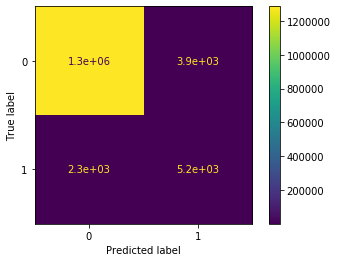

In [252]:
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
plot_confusion_matrix(model, X, y)

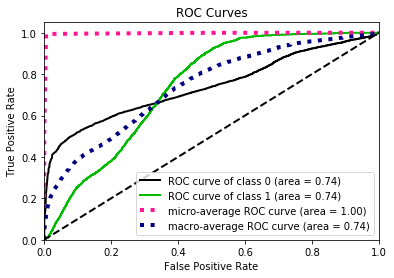

In [253]:
y_true = y_test # ground truth labels
y_probas = model.predict_proba(X_test) # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc(y_true, y_probas)
plt.show()

In [238]:
data_tuples = list(zip(y_true,list(y_probas[:,1])))

In [239]:
compare = pd.DataFrame(data_tuples, columns=['y_true','y_probas'])

In [246]:
compare['y_probas'] = compare['y_probas'].round(2)

In [247]:
compare.to_excel('compare.xlsx', index = False)

In [279]:
train['prev_is_fraud'] = (train.sort_values(by=['unix_time'], ascending=True)
                       .groupby(['cc_num'])['is_fraud'].shift(1))

In [263]:
train.to_excel('aaa.xlsx', index = False)

In [ ]:
train

In [270]:
df = pd.DataFrame({'foo': ['one','one','one','two','two'],
                       'bar': ['A', 'B', 'C', 'A', 'B'],
                       'baz': [1, 2, 3, 4, 5]})
df

,foo,bar,baz
0,one,A,1
1,one,B,2
2,one,C,3
3,two,A,4
4,two,B,5


In [271]:
df.pivot(index='foo', columns='bar', values='baz')

bar,A,B,C
foo,,,
one,1.0,2.0,3.0
two,4.0,5.0,NaN


In [268]:
pivot_df = df.pivot(index='foo', columns='bar')['baz']

In [269]:
pd.DataFrame(pivot_df.to_records())

,foo,A,B,C
0,one,1,2,3
1,two,4,5,6


In [273]:
train.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'prev_is_fraud'], dtype='object')

In [280]:
agg_df = train.groupby(['is_fraud','prev_is_fraud'], as_index=False)\
            .aggregate({'unix_time' : 'count'})\
            .rename(columns = {'unix_time': 'cnt'})

In [281]:
agg_df

,is_fraud,prev_is_fraud,cnt
0,0,0.0,992870
1,0,1.0,521
2,1,0.0,523
3,1,1.0,5123


In [285]:
train.loc[train['cc_num']==4613314721966,:]

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,prev_is_fraud
1023,1023,2019-01-01 12:51:40,4613314721966,"fraud_O'Connell, Botsford and Hand",home,71.03,Jason,Murphy,M,542 Steve Curve Suite 011,Collettsville,NC,28611,35.9946,-81.7266,885,Soil scientist,1988-09-15,ec78ae12af778ef797c8f9ee88c8eafd,1325422300,35.773439,-80.895816,0,NaN
2449,2449,2019-01-02 01:06:37,4613314721966,fraud_Rutherford-Mertz,grocery_pos,281.06,Jason,Murphy,M,542 Steve Curve Suite 011,Collettsville,NC,28611,35.9946,-81.7266,885,Soil scientist,1988-09-15,e8a81877ae9a0a7f883e15cb39dc4022,1325466397,36.430124,-81.179483,1,0.0
2546,2546,2019-01-02 03:38:03,4613314721966,fraud_Erdman-Kertzmann,gas_transport,7.03,Jason,Murphy,M,542 Steve Curve Suite 011,Collettsville,NC,28611,35.9946,-81.7266,885,Soil scientist,1988-09-15,397894a5c4c02e3c61c784001f0f14e4,1325475483,35.909292,-82.091010,1,1.0
2937,2937,2019-01-02 13:38:08,4613314721966,fraud_Medhurst PLC,shopping_net,844.80,Jason,Murphy,M,542 Steve Curve Suite 011,Collettsville,NC,28611,35.9946,-81.7266,885,Soil scientist,1988-09-15,248c2746e78f2ec713df51254ff1b302,1325511488,35.987802,-81.254332,1,1.0
3527,3527,2019-01-02 23:52:08,4613314721966,fraud_Ruecker Group,misc_net,843.91,Jason,Murphy,M,542 Steve Curve Suite 011,Collettsville,NC,28611,35.9946,-81.7266,885,Soil scientist,1988-09-15,2f7d497f607396ab669c14c2abe3886f,1325548328,35.985612,-81.383306,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996818,996818,2020-02-12 00:19:54,4613314721966,fraud_Botsford Ltd,shopping_pos,131.72,Jason,Murphy,M,542 Steve Curve Suite 011,Collettsville,NC,28611,35.9946,-81.7266,885,Soil scientist,1988-09-15,97a8d14b6eeef403c385d7e64518ada5,1360628394,36.144559,-82.134523,0,0.0
998883,998883,2020-02-13 15:51:54,4613314721966,"fraud_Kunze, Larkin and Mayert",travel,527.35,Jason,Murphy,M,542 Steve Curve Suite 011,Collettsville,NC,28611,35.9946,-81.7266,885,Soil scientist,1988-09-15,8e6d1fc56b62c538b56f520a5fa814f2,1360770714,36.349221,-81.481918,0,0.0
998884,998884,2020-02-13 15:55:46,4613314721966,fraud_Douglas-White,entertainment,71.78,Jason,Murphy,M,542 Steve Curve Suite 011,Collettsville,NC,28611,35.9946,-81.7266,885,Soil scientist,1988-09-15,7e93e4f5a16e44275de06c8a46c35073,1360770946,35.081709,-82.349263,0,0.0
999706,999706,2020-02-14 06:43:28,4613314721966,fraud_Deckow-O'Conner,grocery_pos,96.96,Jason,Murphy,M,542 Steve Curve Suite 011,Collettsville,NC,28611,35.9946,-81.7266,885,Soil scientist,1988-09-15,7a206954ad3f06447f0f723660875d30,1360824208,36.617523,-80.811790,0,0.0
